# Major Transports
Transport diagnostics from each of the major straits.


In [74]:
%matplotlib inline

from cosima_cookbook import get_nc_variable, expts, build_index
from cosima_cookbook import memory
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [70]:
straights = [ {'name': 'DrakePassage', 'xloc':2100,'ymin':225,'ymax':650},
              {'name': 'Lombok',       'yloc':1158,'xmin':354,'xmax':361},
              {'name': 'Ombai',        'xloc':449,'ymin':1152,'ymax':1163},
              {'name': 'Timor',        'xloc':440,'ymin':1125,'ymax':1145},
              {'name': 'Bering',       'yloc':2125,'xmin':1080,'xmax':1130},
              {'name': 'Denmark',      'yloc':2125,'xmin':2380,'xmax':2580},
            ]

In [62]:
xu_ocean = get_nc_variable('mom01v5/KDS75', 'ocean_grid', 'xu_ocean', n=1).isel(time=0)
yu_ocean = get_nc_variable('mom01v5/KDS75', 'ocean_grid', 'yu_ocean', n=1).isel(time=0)

/short/v45/jm0634/conda/envs/cosima/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


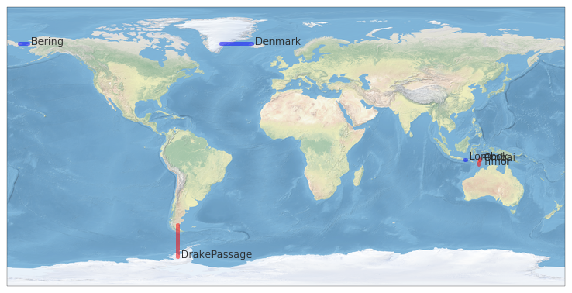

In [68]:
import cartopy.crs as ccrs

plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

for straight in straights:

    if 'xloc' in straight:
        xloc = straight['xloc']
        ymin = straight['ymin']
        ymax = straight['ymax']
        
        plt.plot([xu_ocean[xloc], xu_ocean[xloc]],
                 [yu_ocean[ymin], yu_ocean[ymax]],

            color='red', linewidth=4,alpha=0.5,
             transform=ccrs.Geodetic(),
         )
        
        plt.text(xu_ocean[xloc]+2, yu_ocean[ymin], straight['name'],
         horizontalalignment='left',
        transform=ccrs.Geodetic()
        )
    else:
        yloc = straight['yloc']
        xmin = straight['xmin']
        xmax = straight['xmax']
        
        plt.plot([xu_ocean[xmin], xu_ocean[xmax]],
                 [yu_ocean[yloc], yu_ocean[yloc]],

             color='blue', linewidth=4,alpha=0.5,
             transform=ccrs.Geodetic(),
         )
        
        plt.text(xu_ocean[xmax]+2, yu_ocean[yloc], straight['name'],
         horizontalalignment='left',
        transform=ccrs.Geodetic()
        )

ax.stock_img()
ax.set_global()
plt.show()

In [75]:
@memory.cache
def calc_transport(expt, straight):
    ## Function to calculate barotropic transport across a given line of latitude or longitude.
    ## Primarily designed for flow through straits.
    
    print('Calculating {}:{} transport'.format(expt, straight['name']))
    
    if 'xloc' in straight:

        ymin, ymax = straight['ymin'], straight['ymax']
        xloc = straight['xloc']
        
        op = lambda p: p.isel(xu_ocean=xloc)\
                        .isel(yt_ocean=slice(ymin, ymax))\
                        .chunk({'time':1})\
                        .sum('st_ocean').sum('yt_ocean')
                     
        transport = get_nc_variable(expt, 'ocean.nc', 'tx_trans',
                                    chunks=None,
                                    op=op)

    elif 'yloc' in straight:

        xmin, xmax = straight['xmin'], straight['xmax']
        yloc = straight['yloc']
        
        op = lambda p: p.isel(yu_ocean=yloc)\
                        .isel(xt_ocean=slice(xmin, xmax))\
                        .chunk({'time':1})\
                        .sum('st_ocean').sum('xt_ocean')
                
        transport = get_nc_variable(expt, 'ocean.nc', 'ty_trans',
                                    chunks=None,
                                    op=op)
    else:
        print('Transports must be along lines of either constant latitude or longitude')
        return None
    
    transport = transport.load()
       
    return transport

When distributing a computing with dask, you should try and minimize the number of task while
keeping each task appropriate to a single work regarding memory usage.

/short/v45/jm0634/conda/envs/cosima/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


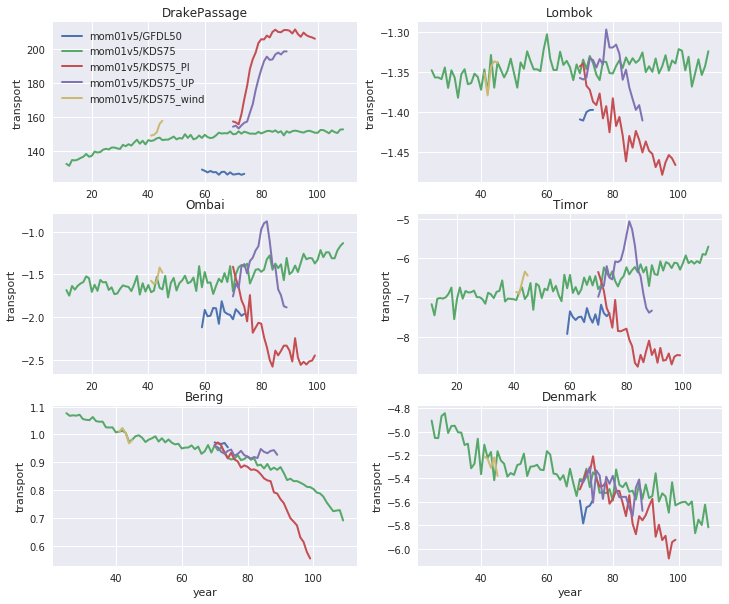

In [77]:
plt.figure(figsize=(12,10))

for expt in expts:
    if 'mom025' in expt:
        # need to change straights from grid coordinates to real word positions
        continue
        
    nplot = 0
    
    for straight in straights:
        nplot += 1
       
        transport = calc_transport(expt, straight)
        
        # see https://github.com/spencerahill/aospy/issues/98#issuecomment-256043833
        da = transport.to_dataset(name='transport')
                                
        periods = []
        for date in da['time']:
            raw_date = date.values.item()
            periods.append(pd.Period(year=raw_date.year, month=raw_date.month, 
                                     day=raw_date.day, freq='D'))
        da['time'] = pd.PeriodIndex(periods)
        da = da.groupby('time.year').mean('time')
        transport = da.transport
        
        plt.subplot(3, 2, nplot)
        transport.plot(label=expt, linewidth=2)
        plt.title( straight['name'])
        
plt.subplot(321)
plt.legend(loc='upper left')
#plt.ylabel('Transport (Sv)')
plt.xlabel('')
plt.subplot(322)
#plt.ylabel('')
plt.xlabel('')
plt.subplot(323)
#plt.ylabel('Transport (Sv)')
plt.xlabel('')
plt.subplot(324)
#plt.ylabel('')
plt.xlabel('')
plt.subplot(325)
#plt.ylabel('Transport (Sv)')
#plt.xlabel('Time')
plt.subplot(326)
#plt.ylabel('')
#plt.xlabel('Time')